In [357]:
import cv2
import time
import argparse
import numpy as np
from PIL import Image
from keras.models import model_from_json
from utils.anchor_generator import generate_anchors
from utils.anchor_decode import decode_bbox
from utils.nms import single_class_non_max_suppression
from load_model.keras_loader import load_keras_model, keras_inference
from IPython.display import display
import scipy.io as io

# LabelTestAll.mat 這個東西好像有問題，似乎 xml 的資料才有修正過

### labels array 第 5 個代表的意義
 1. masked face
 2. unmasked face
 3. invalid face.

In [304]:
ROOT_IMAGE_PATH = 'test_image/'
TYPE = 'LabelTest'
labels = io.loadmat('LabelTestAll.mat')
labels = labels[TYPE][0]
labels[2][1]

array([[352, 114, 151, 151,   1,  17,  45, 137, 135,   1,   3,   2,   2,
          3,  -1,  -1,  -1,  -1],
       [799, 217, 139, 139,   2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1]], dtype=int16)

In [66]:
labels[0][0][0]

'test_00000001.jpg'

In [24]:
model = load_keras_model(
    "models/face_mask_detection.json", "models/face_mask_detection.hdf5"
)

# anchor configuration
feature_map_sizes = [[33, 33], [17, 17], [9, 9], [5, 5], [3, 3]]
anchor_sizes = [[0.04, 0.056], [0.08, 0.11], [0.16, 0.22], [0.32, 0.45], [0.64, 0.72]]
anchor_ratios = [[1, 0.62, 0.42]] * 5

# generate anchors
anchors = generate_anchors(feature_map_sizes, anchor_sizes, anchor_ratios)

# for inference , the batch size is 1, the model output shape is [1, N, 4],
# so we expand dim for anchors to [1, anchor_num, 4]
anchors_exp = np.expand_dims(anchors, axis=0)

id2class = {0: "Mask", 1: "NoMask"}

# 有戴口罩 0 沒帶: 1 
## label 的有戴口罩 1 沒帶: 2

In [235]:
def inference(image,conf_thresh=0.5,iou_thresh=0.4,target_shape=(160, 160),draw_result=True,show_result=True):
    output_info = []
    height, width, _ = image.shape
    image_resized = cv2.resize(image, target_shape)
    image_np = image_resized / 255.0  # 归一化到0~1
    image_exp = np.expand_dims(image_np, axis=0)
    y_bboxes_output, y_cls_output = keras_inference(model, image_exp)
    # remove the batch dimension, for batch is always 1 for inference.
    y_bboxes = decode_bbox(anchors_exp, y_bboxes_output)[0]
    y_cls = y_cls_output[0]
    # To speed up, do single class NMS, not multiple classes NMS.
    bbox_max_scores = np.max(y_cls, axis=1)
    bbox_max_score_classes = np.argmax(y_cls, axis=1)
    # keep_idx is the alive bounding box after nms.
    keep_idxs = single_class_non_max_suppression(y_bboxes, bbox_max_scores, conf_thresh=conf_thresh, iou_thresh=iou_thresh)
    for idx in keep_idxs:
        conf = float(bbox_max_scores[idx])
        class_id = bbox_max_score_classes[idx]
        bbox = y_bboxes[idx]
        # clip the coordinate, avoid the value exceed the image boundary.
        xmin = max(0, int(bbox[0] * width))
        ymin = max(0, int(bbox[1] * height))
        xmax = min(int(bbox[2] * width), width)
        ymax = min(int(bbox[3] * height), height)
        if draw_result:
            if class_id == 0:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(image,f"{id2class[class_id]}: {np.round(conf,3)}",(xmin + 2, ymin - 2),cv2.FONT_HERSHEY_SIMPLEX,0.8,color,)
        output_info.append([class_id, conf, xmin, ymin, xmax, ymax])
    if show_result:
        display(Image.fromarray(image))
        pass
    return output_info

In [236]:
def show(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return inference(img, show_result=True, target_shape=(260, 260))

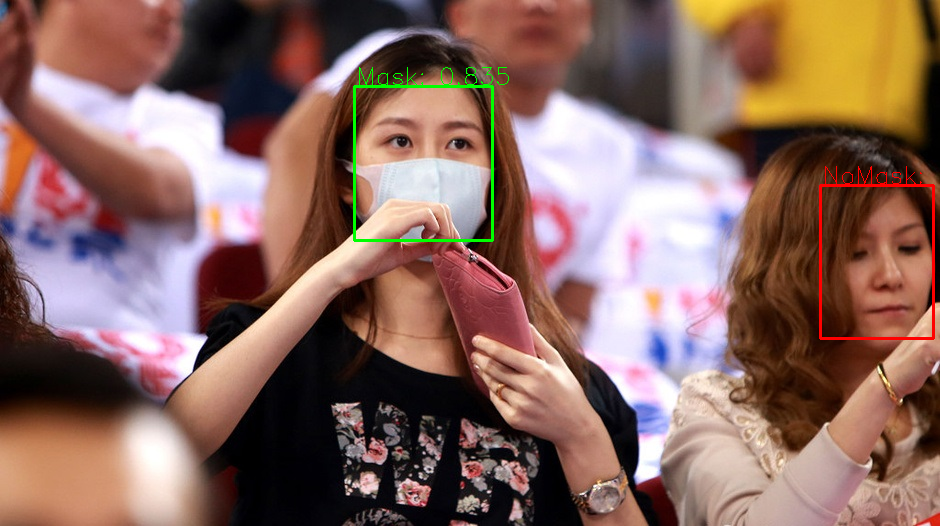

[[1, 0.9993515610694885, 820, 185, 933, 338],
 [0, 0.8351307511329651, 354, 86, 492, 240]]

In [303]:
show(ROOT_IMAGE_PATH+'test_00000003.jpg')

In [76]:
All_result = []
for i,pic in enumerate(labels):
    temp_res = []
    for res in show(ROOT_IMAGE_PATH+pic[0][0]):
        temp_res.append(res[0])
    All_result.append(temp_res)
    if i%100 == 0:
        print(f"Processing ... {i}")
All_result

Processing ... 0
Processing ... 100
Processing ... 200
Processing ... 300
Processing ... 400
Processing ... 500
Processing ... 600
Processing ... 700
Processing ... 800
Processing ... 900
Processing ... 1000
Processing ... 1100
Processing ... 1200
Processing ... 1300
Processing ... 1400
Processing ... 1500
Processing ... 1600
Processing ... 1700
Processing ... 1800
Processing ... 1900
Processing ... 2000
Processing ... 2100
Processing ... 2200
Processing ... 2300
Processing ... 2400
Processing ... 2500
Processing ... 2600
Processing ... 2700
Processing ... 2800
Processing ... 2900
Processing ... 3000
Processing ... 3100
Processing ... 3200
Processing ... 3300
Processing ... 3400
Processing ... 3500
Processing ... 3600
Processing ... 3700
Processing ... 3800
Processing ... 3900
Processing ... 4000
Processing ... 4100
Processing ... 4200
Processing ... 4300
Processing ... 4400
Processing ... 4500
Processing ... 4600
Processing ... 4700
Processing ... 4800
Processing ... 4900


[[],
 [0],
 [1, 0],
 [0],
 [1, 0, 1],
 [0, 0, 0],
 [0],
 [1, 0],
 [0],
 [0],
 [0, 0],
 [0],
 [0],
 [0, 1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 0],
 [0],
 [0],
 [0, 1, 1],
 [0],
 [0],
 [1, 1, 0, 1],
 [0],
 [0],
 [0, 1],
 [0],
 [0, 1, 1, 1, 1],
 [0],
 [1, 1, 0],
 [0],
 [0],
 [0, 0],
 [0, 1, 0, 1],
 [0],
 [0, 1],
 [0, 1],
 [0],
 [1, 0],
 [0, 0, 1, 0],
 [0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 0],
 [0],
 [0, 0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 1, 1],
 [0, 1],
 [0],
 [0],
 [0],
 [],
 [0, 0, 0],
 [0],
 [0, 1],
 [1],
 [0],
 [1, 1, 1],
 [0, 0, 0],
 [1, 1],
 [0, 0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [1, 0],
 [0],
 [0, 0],
 [0],
 [0, 1],
 [0],
 [0],
 [],
 [0],
 [1, 1, 0, 1, 1, 1, 1],
 [0],
 [0],
 [0, 1],
 [],
 [1],
 [0],
 [1],
 [1, 1, 1],
 [0],
 [0, 0],
 [0],
 [],
 [0],
 [0],
 [0],
 [1, 0],
 [0],
 [0],
 [0],
 [0],
 [0, 1],
 [1, 1, 1, 1],
 [0],
 [0],
 [0],
 [0],
 [1],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 0],
 [0],
 [0],
 [0, 0, 0],


## Postive - 有戴口罩 1
## Negtive - 沒戴口罩 0

In [333]:
FN = 0
FP = 0
TP = 0
TN = 0

valid = 0

watch = []


for i,label in enumerate(labels):   
    
    ## 只看有全部偵測到的
    if len(label[1]) == len(All_result[i]):
        res = []
        for real in label[1]:
            # 跳過 invalid 的
            if real[4] == 3:
                pass
            #  沒戴口罩
            if real[4] == 2:
                res.append(0)
            #  有戴口罩
            if real[4] == 1:
                res.append(1)
                
        r_mask = sum(res)
        r_unmask = len(res) - r_mask         

        
        
        res = [] 
        for pred in All_result[i]:
            #  有戴口罩
            if pred == 0:
                res.append(1)
            #  沒戴口罩
            else:
                res.append(0)
                
        p_mask = sum(res)
        p_unmask = len(res) - p_mask
       
        if p_mask == r_mask:
            TP += p_mask
        # 有戴口罩卻認為他沒帶
        elif p_mask < r_mask and p_unmask > r_unmask:
            FN += r_mask - p_mask
            TP += p_mask
            watch.append(i)
            
        if p_unmask == r_unmask:
            TN += p_unmask
            
        # 沒戴口罩卻認為他有帶
        elif p_unmask < r_unmask and p_mask > r_mask:
            FP += r_unmask - p_unmask
            TN += p_unmask
            
        valid += 1

In [334]:
valid

3948

In [335]:
FN 

1062

In [336]:
FP 

3

In [337]:
TP 

3528

In [338]:
TN

158

In [339]:
TP/(TP+FN)

0.7686274509803922

In [340]:
TN/(TN+FP)

0.9813664596273292

In [353]:
watch[5]

77

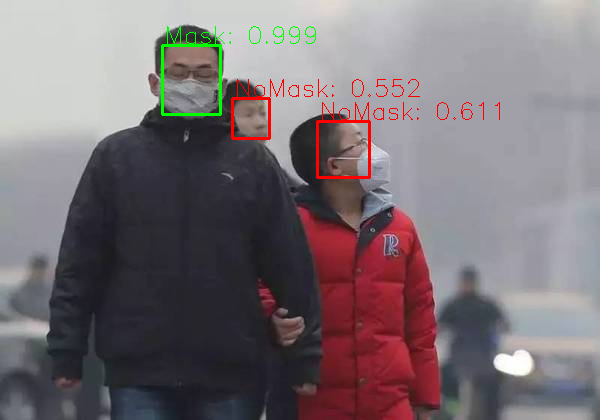

[[0, 0.9990645051002502, 162, 45, 220, 114],
 [1, 0.6106680631637573, 317, 121, 369, 177],
 [1, 0.5516221523284912, 232, 98, 269, 138]]

In [342]:
show(ROOT_IMAGE_PATH+'test_00000057.jpg')

In [328]:
# 後面的小朋友看起來也沒戴口罩
labels[56][1]

array([[154,  59,  66,  66,   1,   7,  19,  68,  61,   2,   3,   1,   2,
          3,  13,  10,  48,  16],
       [218, 100,  60,  60,   1,  30,  40,  51,  49,   3,   1,   1,   2,
          4,  -1,  -1,  -1,  -1],
       [308, 126,  86,  86,   1,  52,  16,  83,  71,   2,   3,   1,   2,
          5,  44,  13,  22,  14]], dtype=int16)

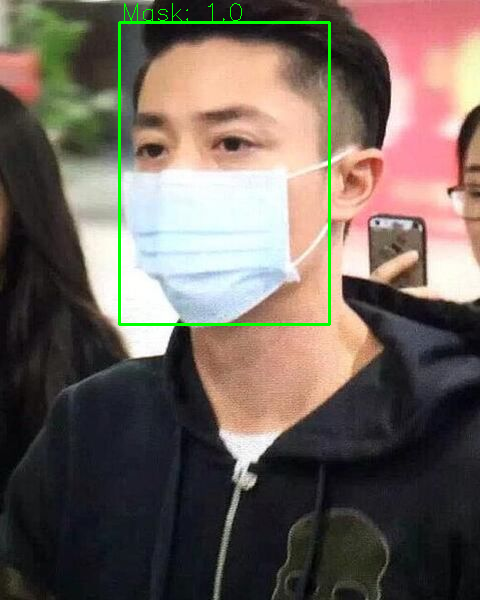

[[0, 0.9999949932098389, 119, 22, 329, 324]]

In [356]:
show(ROOT_IMAGE_PATH+'test_00000002.jpg')

In [327]:
# 但是後面的明顯沒戴口罩 
labels[57][1]

array([[116,  37,  46,  46,   1,   9,  16,  43,  46,   2,   3,   1,   2,
          3,   4,   5,  36,  13],
       [113,   2,  43,  43,   1,  10,  21,  44,  44,   3,   2,   1,   2,
          3,   6,   5,  33,  11]], dtype=uint8)

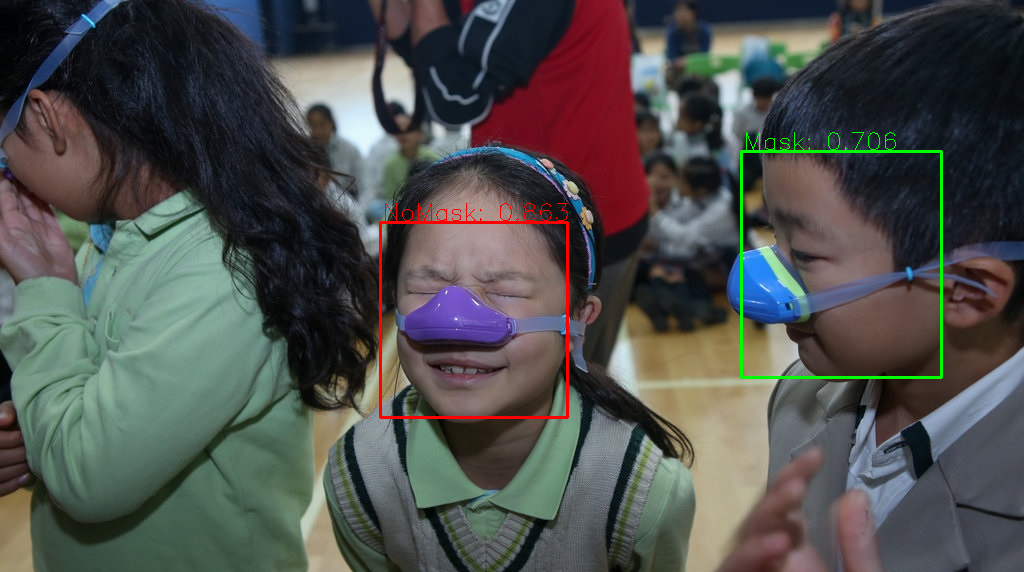

[[1, 0.8632468581199646, 380, 222, 567, 417],
 [0, 0.706075131893158, 741, 151, 941, 377]]

In [354]:
show(ROOT_IMAGE_PATH+'test_00000078.jpg')

In [355]:
# 但 label 給的是兩個都有帶
labels[77][1]

array([[382, 250, 171, 171,   1,  22,  44, 134,  98,   1,   1,   2,   2,
          3,  -1,  -1,  -1,  -1],
       [712, 172, 212, 212,   1,  14,  76, 102, 152,   1,   1,   1,   2,
          1,  -1,  -1,  -1,  -1]], dtype=int16)